สามารถโหลด Dataset ที่ใช้ได้ที่ 
https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [97]:
import os
import string
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.backend import clear_session
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import time
from PIL import Image
import re

In [98]:
captions = pd.read_csv('captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [99]:
captions['image_path'] = captions['image'].apply(
    lambda x: 'Images/'+x)

In [100]:
captions.head()

,image,caption,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,Images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,Images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,Images/1000268201_693b08cb0e.jpg


In [101]:
clear_session()

### 1. Feature Extraction 
ใช้ Model Inception ในการทำ Feature Extraction โดยแยก Object Feature จากรูปภาพให้อยู่ในรูปแบบของ Vector

In [102]:
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
inception_v3.trainable = False

ทำการใช้ Model ที่กำหนดมาทำนาย Predict หา feature vector จากรูปภาพ โดย Dataset ที่ใช้คือ flickr30k

In [103]:
def load_image(path):
    '''
    pre-process image
    '''
    # load image from disk
    img = tf.io.read_file(path)
    # make it a tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize it to 299 X 299
    img = tf.keras.layers.Resizing(299, 299)(img)
    # apply inception v3 preprocessing
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, path

In [104]:
unique_img_paths = sorted(list(captions['image_path'].unique()))


image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_paths)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(128)

In [105]:
# Let's iterate through all the image paths, load it with our
# `load_img()` function and save it in the feature_vectors 
# directory
features = {}

for img, paths in tqdm(image_dataset, total=len(image_dataset)):
    feature_vector = inception_v3(img)
    # the feature_vector is of shape
    # (batch_size, 8, 8, 2048)
    
    feature_vector = tf.reshape(
        feature_vector,
        (feature_vector.shape[0], -1, feature_vector.shape[3])
    )
    # now it is of shape (batch_size, 8*8, 2048) = 
    # (batch_size, 64, 2048)
    
    for fv, path in zip(feature_vector, paths):
        path = path.numpy().decode("utf-8")
        path = path.split('/')[1]
        features[path] = fv.numpy()

  0%|          | 0/64 [00:00<?, ?it/s]

In [106]:
len(features)

8091

ทำการ Save file Feature Vector ที่ Extract ได้จากรูปภาพทั้งหมด ผ่านไฟล์ .pkl สำหรับใช้ภายในการเทรนโมเดล

In [107]:
# #With Pretrained
# filepath = os.path.join('save', 'features.pkl')
# #store features in pickle
# pickle.dump(features, open(filepath, 'wb'))


In [108]:
# # load features from pickle
# with open(filepath, 'rb') as f:
#     features = pickle.load(f)

In [109]:
# with open("captions30k.txt", 'r') as f:
#     next(f)
#     captions_doc = f.read()

### Preprocess

In [110]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   words = text.split()
   filtered_words = filter(lambda word: len(word) > 1, words)
   return " ".join(filtered_words)

def remove_numeric(text):
   words = text.split()
   filtered_words = filter(lambda word: word.isalpha(), words)
   return " ".join(filtered_words)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(captions.caption.values):
   newcaption = text_clean(caption)
   captions["caption"].iloc[i] = newcaption

In [111]:
all_captions = []
for caption  in captions["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

In [112]:
all_img_name_vector = []
for annot in captions["image"]:
   full_image_path = "Images/" + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg']

In [113]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [114]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector
40000
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [115]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [116]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))


Max Length of any caption : Min Length of any caption = 33 : 2


In [117]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [118]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 64

In [119]:
def map_func(img_name, cap):
    img_name = img_name.decode('utf-8').split('/')[1]
    img_tensor = features[img_name]
    return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [120]:
class CNN_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(CNN_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [121]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [122]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   # Bahdanau attention
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,64,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 64, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,64,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,64,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,64,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


In [123]:
clear_session()
encoder = CNN_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [124]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [125]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [126]:
EPOCHS = 30
for epoch in range(EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6918
Epoch 1 Batch 100 Loss 1.8236
Epoch 1 Batch 200 Loss 1.3612
Epoch 1 Batch 300 Loss 1.4472
Epoch 1 Batch 400 Loss 1.3140
Epoch 1 Loss 1.467172
Time taken for 1 epoch 529.0453262329102 sec

Epoch 2 Batch 0 Loss 1.2635
Epoch 2 Batch 100 Loss 1.2086
Epoch 2 Batch 200 Loss 1.0960
Epoch 2 Batch 300 Loss 1.2292
Epoch 2 Batch 400 Loss 1.0797
Epoch 2 Loss 1.147781
Time taken for 1 epoch 565.29429936409 sec

Epoch 3 Batch 0 Loss 1.0590
Epoch 3 Batch 100 Loss 1.0633
Epoch 3 Batch 200 Loss 1.0544
Epoch 3 Batch 300 Loss 1.0750
Epoch 3 Batch 400 Loss 0.8969
Epoch 3 Loss 1.030299
Time taken for 1 epoch 362.08176445961 sec

Epoch 4 Batch 0 Loss 0.8824
Epoch 4 Batch 100 Loss 1.0107
Epoch 4 Batch 200 Loss 0.8568
Epoch 4 Batch 300 Loss 0.9467
Epoch 4 Batch 400 Loss 0.8898
Epoch 4 Loss 0.948837
Time taken for 1 epoch 361.2384889125824 sec

Epoch 5 Batch 0 Loss 0.8158
Epoch 5 Batch 100 Loss 0.9103
Epoch 5 Batch 200 Loss 0.8528
Epoch 5 Batch 300 Loss 0.9437
Epoch 5 Batch 400 Loss

KeyboardInterrupt: 

In [127]:
import matplotlib.pyplot as plt

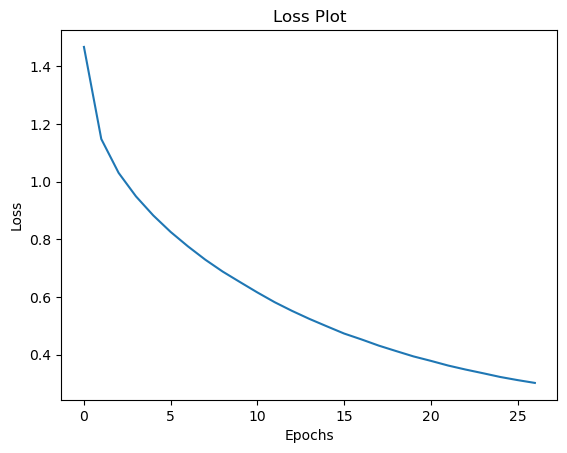

In [128]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [129]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = inception_v3(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [130]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [131]:
from nltk.translate.bleu_score import sentence_bleu

In [174]:
def showresult(image,real_caption):
    im = Image.open(image)
    plt.imshow(im)
    plt.show()
    # real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    # remove <start> and <end> from the real_caption
    first = real_caption.split(' ', 1)[1]
    #remove "<unk>" in result
    for i in result:
        if i=="<unk>":
            result.remove(i)
    #remove <end> from result        
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = result

    score = sentence_bleu(reference, candidate)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', result_final)
    plot_attention(image, result, attention_plot)

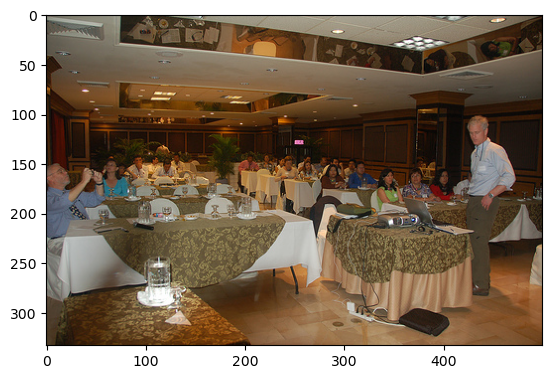

c:\Users\seire\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\seire\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\seire\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

BELU score: 5.483065946899793e-230
Real Caption: A dining room full of people eating and a waiter serving them
Prediction Caption: people are gathered in the background


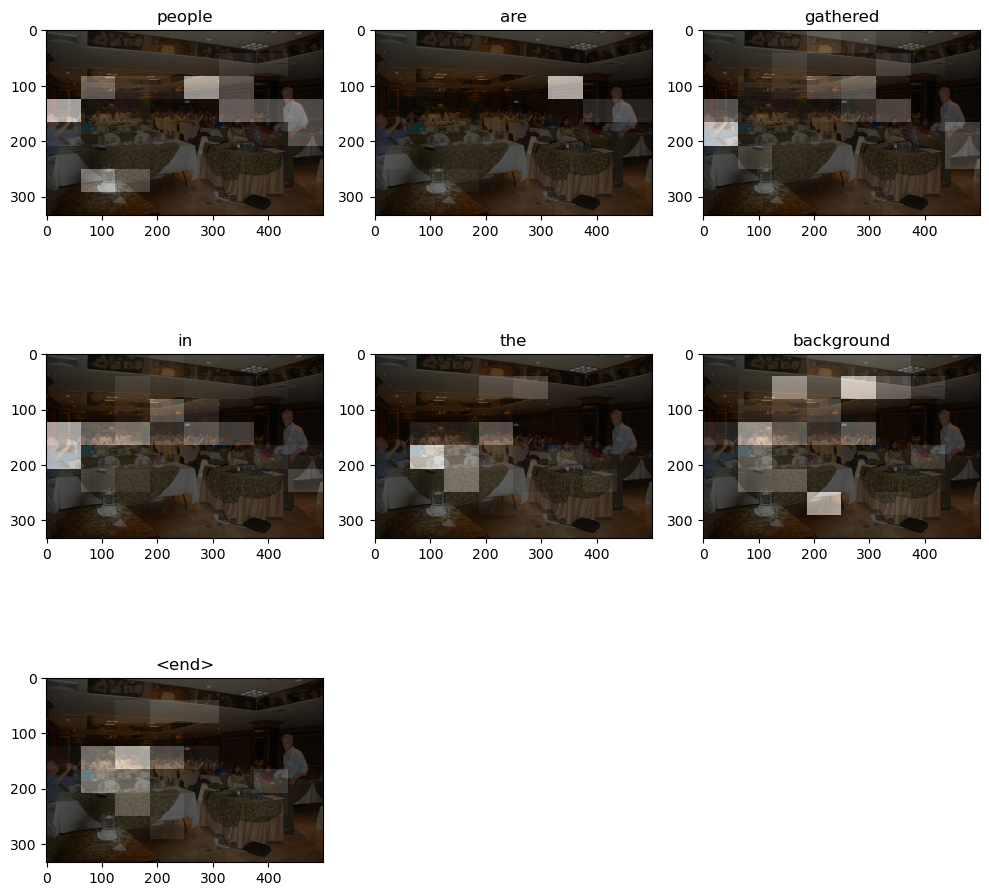

In [175]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = 'Images30k/96395587.jpg'

showresult(image,'A dining room full of people eating and a waiter serving them')

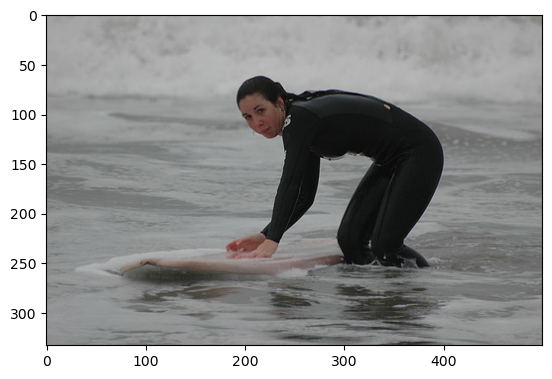

BELU score: 0
Real Caption: A female surfer
Prediction Caption: woman in wetsuit aids fish in need of attention


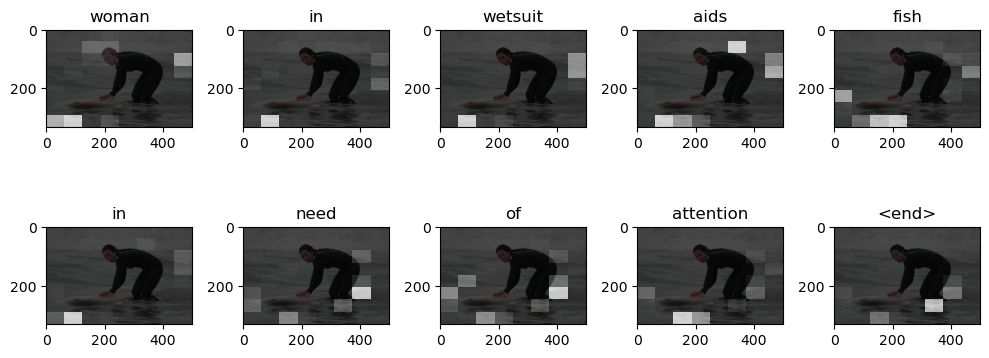

In [172]:
image = 'Images30k/2201951969.jpg'
showresult(image,'A female surfer')

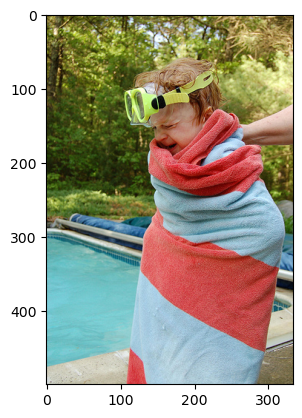

BELU score: 9.594503055152631e-230
Real Caption: A wet crying baby wrapped in a red and blue towel
Prediction Caption: young girl wearing pink dress is playing in the pool with water


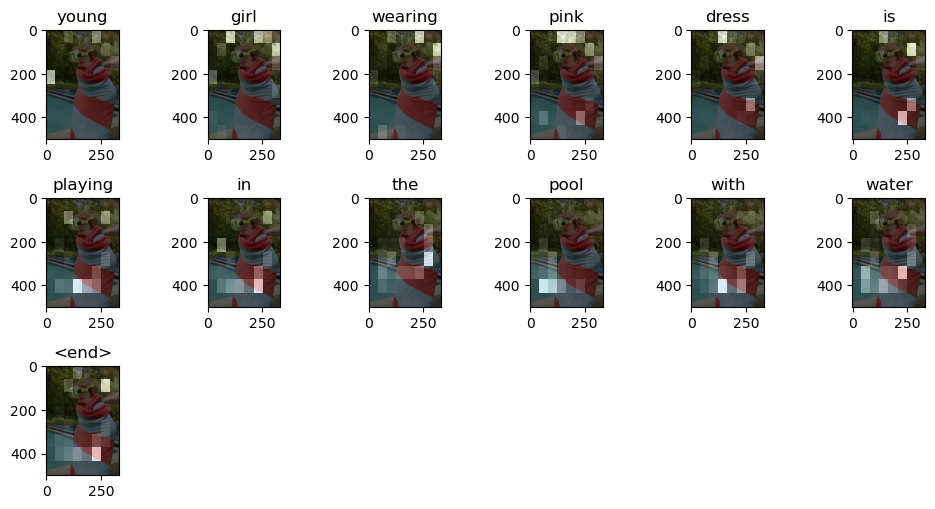

In [177]:
image = 'Images30k/2204545235.jpg'
showresult(image,'A wet crying baby wrapped in a red and blue towel')

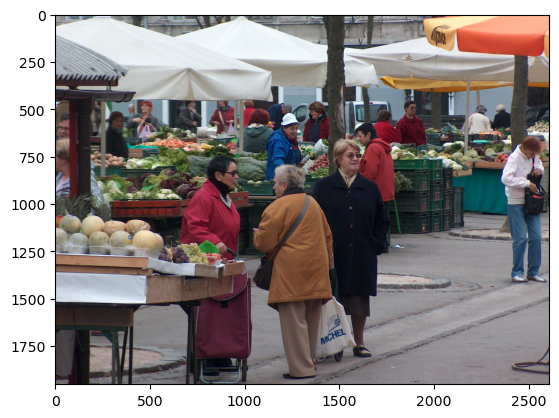

BELU score: 0
Real Caption: surfer rides a surfboard in the ocean
Prediction Caption: crowd of people are watching some flowers and red outdoor market


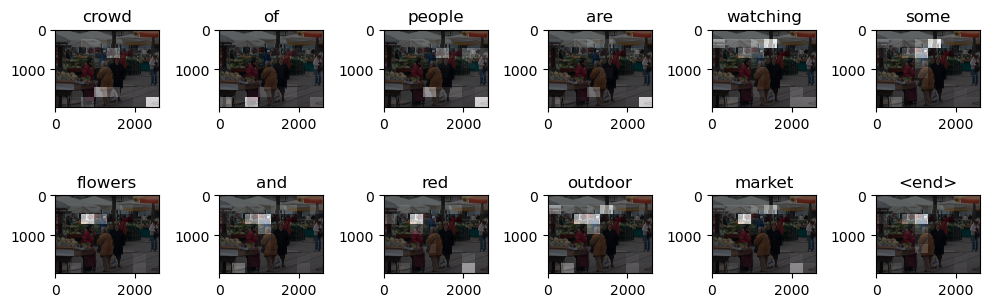

In [201]:
image = 'Test/9.jpg'
showresult(image,'surfer rides a surfboard in the ocean')

Real Caption: man has his arms around two women who are posing for picture with him
Prediction Caption: woman dressed as two women stand nearby under an umbrella


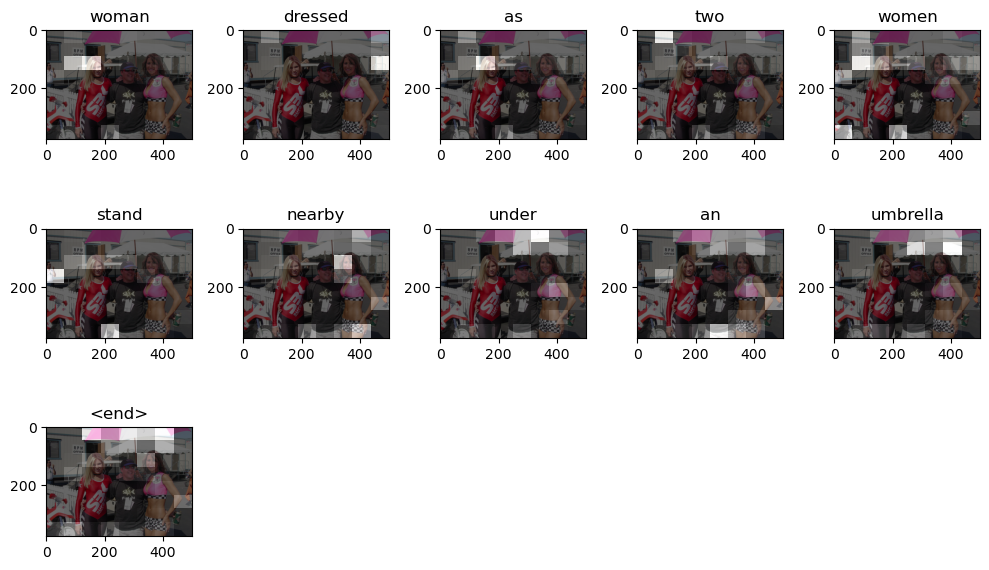

time took to Predict: 2 sec


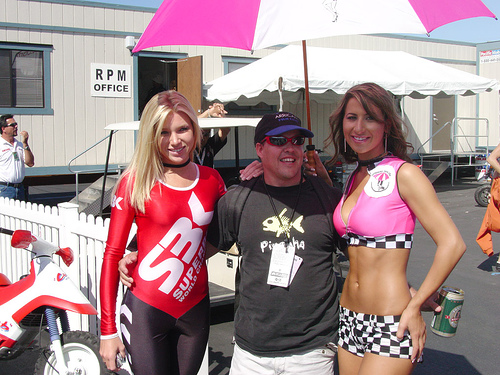

In [148]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)



first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]
#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

BELU score: 3.7005922416742967e-153
Real Caption: two white dogs look at one black dog on paved walkway
Prediction Caption: two small dogs sniff one in the black and one black and one black and one black and one black and one black and one black and one black and one black


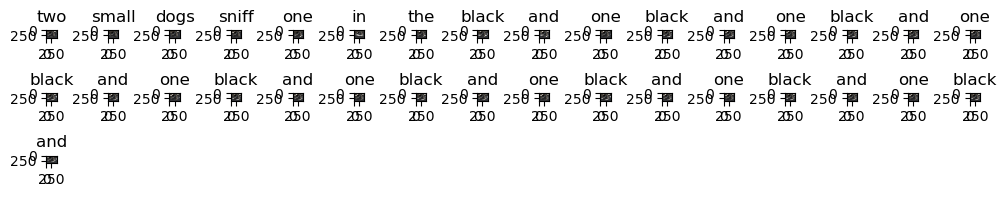

In [152]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)